In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../utils')
print(sys.path)
import numpy as np
from load_dataset import *
import os

['/home/shiqi/code/model_combination_Argos/pca_from_formulation', '/home/shiqi/anaconda3/envs/torch/lib/python39.zip', '/home/shiqi/anaconda3/envs/torch/lib/python3.9', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/lib-dynload', '', '/home/shiqi/anaconda3/envs/torch/lib/python3.9/site-packages', '../utils']


In [4]:
import yaml

config_path = '/home/shiqi/code/model_combination_Argos/pca_from_formulation/output/experiment_2/config.yaml'
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [5]:
save_dir = config['save_dir']
train_data_dir = config['data_dir']
test_data_dir = '/home/shiqi/code/model_combination_Argos/data_linear_1000_test'

train_loss = np.load(os.path.join(save_dir, 'train_losses.npy'))
test_loss = np.load(os.path.join(save_dir, 'test_losses.npy'))


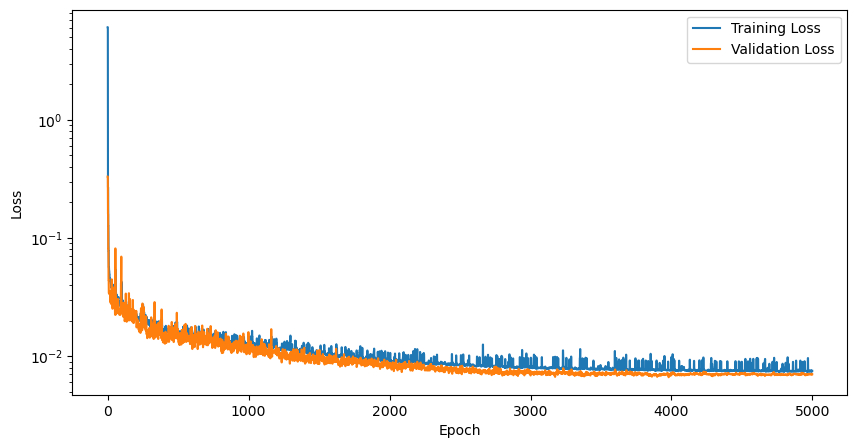

In [6]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(10,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

In [7]:
import pca_koopman_dir as km
import torch

# Device
device = 'cpu'
print('Device:', device)

# todo: multi nu
nu = config['nu']
nu_list = [nu]

# Data loader
x_data, u_data, nu_data, n_features, n_inputs = data_preparation_xu(config, nu_list, nu)

# Params
params = km.Params(n_features, n_inputs, config)

# Model
model = km.build_model_MatrixWithInputs(params, x_data, u_data)
model = model.to(device)

Device: cpu


In [8]:
model.load_state_dict(torch.load(os.path.join(save_dir, 'model.pth'), map_location=device))

<All keys matched successfully>

In [20]:
begin, end = 50, 150
x_dataset = []
u_dataset = []

data_dir = test_data_dir
for item in os.listdir(data_dir):
    data_file_path = os.path.join(data_dir, item)

    # Check if the file exists before trying to load it
    if os.path.exists(data_file_path):
        data_dict = np.load(data_file_path, allow_pickle=True).item()
        x_data, _, u_data, _ = load_dataset(data_dict)
        x_dataset.append(x_data[begin:end,:])
        u_dataset.append(u_data[begin:end,:])
    else:
        print(f"File not found: {data_file_path}")

In [21]:
len(x_dataset)

10

In [22]:
# start from the zero point
nu = torch.tensor([1000])
x_dataset_pred = []
x_dataset_true = []
x_pca_dataset_pred = []
x_pca_dataset_true = []
nu = torch.tensor(build_nu(nu_list, 1, nu), dtype=torch.int16)
nu = nu.reshape((1, -1))
for x_data, u_data in zip(x_dataset, u_dataset):
    steps = end - begin   

    x_data = torch.tensor(x_data, dtype=torch.float32).to(device)
    u_data = torch.tensor(u_data, dtype=torch.float32).to(device)
    x_pred = torch.zeros_like(x_data).to(device)
    x_pred[0, :] = x_data[0, :]
    x0_pca = model.encode(x_data[0, :].reshape(1, -1))
    for step in range(1, steps):
        u = u_data[step-1, :].reshape(1, -1)
        x1_pca = model.pca_forward(x0_pca, u, nu)
        x_pred[step, :] = model.pca_decode(x1_pca)
        x0_pca = x1_pca
    x_dataset_pred.append(x_pred.detach().cpu().numpy())
    x_dataset_true.append(x_data.detach().cpu().numpy())
    x_pca_true = model.std_layer_1.transform(x_data.detach())
    x_pca_true = model.pca_transformer.transform(x_pca_true)
    x_pca_pred = model.std_layer_1.transform(x_pred.detach())
    x_pca_pred = model.pca_transformer.transform(x_pca_pred)
    x_pca_dataset_true.append(x_pca_true)
    x_pca_dataset_pred.append(x_pca_pred)
        



In [23]:
errors = [x_dataset_true[i] - x_dataset_pred[i] for i in range(len(x_dataset_true))]
errors_pca = [x_pca_dataset_true[i] - x_pca_dataset_pred[i] for i in range(len(x_pca_dataset_true))]

cumulative_error_norms = [np.array([np.linalg.norm(errors[i][:j+1,:]) for j in range(errors[i].shape[0])]) for i in range(len(errors))]
cumulative_error_norms_pca = [np.array([np.linalg.norm(errors_pca[i][:j+1,:]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))]

data_norms = [np.linalg.norm(x_dataset_true[i]) for i in range(len(x_dataset_true))]

data_norms_pca = [np.linalg.norm(x_pca_dataset_true[i]) for i in range(len(x_pca_dataset_true))]

relative_errors = [cumulative_error_norms[i] / data_norms[i] for i in range(len(cumulative_error_norms))] 

mean_relative_errors = np.mean(relative_errors, axis=0)
std_relative_errors = np.std(relative_errors, axis=0)   

In [24]:
relative_errors[-1]

array([0.        , 0.00618126, 0.00737702, 0.03005127, 0.03808001,
       0.04759619, 0.06229749, 0.0751372 , 0.0876305 , 0.09719647,
       0.10718966, 0.11598783, 0.12432842, 0.13314731, 0.14200722,
       0.15200438, 0.1615739 , 0.17242616, 0.18220793, 0.19044812,
       0.19574419, 0.20006381, 0.20220728, 0.2027468 , 0.20299254,
       0.20311324, 0.20423472, 0.20665874, 0.21003303, 0.2140264 ,
       0.21851787, 0.22298893, 0.22813497, 0.23338947, 0.2393269 ,
       0.24604975, 0.25151098, 0.25622407, 0.260001  , 0.26325366,
       0.26564002, 0.26725706, 0.26843786, 0.26947156, 0.27006084,
       0.27065662, 0.27145207, 0.2715953 , 0.27164075, 0.27165177,
       0.2717452 , 0.27202138, 0.27280545, 0.27384   , 0.27535665,
       0.2783933 , 0.28217325, 0.28521883, 0.28821114, 0.29053912,
       0.29244316, 0.29405278, 0.29509804, 0.29606658, 0.29706803,
       0.29726058, 0.29728502, 0.29736444, 0.2973868 , 0.29751006,
       0.29776445, 0.29872292, 0.3021544 , 0.30551702, 0.30900

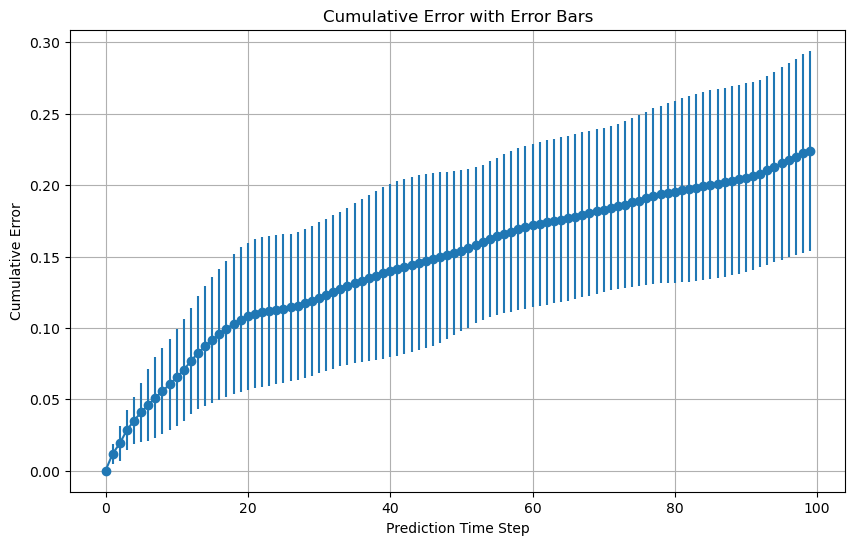

In [25]:

# Plot the relative error with error bars
plt.figure(figsize=(10, 6))
plt.errorbar(range(steps), mean_relative_errors, yerr=std_relative_errors, fmt='-o')
plt.xlabel('Prediction Time Step')
plt.ylabel('Cumulative Error')
plt.title('Cumulative Error with Error Bars')
plt.grid(True)
plt.show()

In [26]:
domain_error_norms = [np.linalg.norm(errors[i]) for i in range(len(x_dataset))]
domain_relative_error = [domain_error_norms[i]/data_norms[i] for i in range(len(domain_error_norms))]
print(np.mean(domain_relative_error))

0.22386365


In [27]:
# import numpy as np
# import matplotlib.pyplot as plt

# k = 1
# n_dimensions = x_dataset_true[k].shape[1]
# selected_dimensions = np.random.choice(n_dimensions, 20, replace=False)

# fig, axs = plt.subplots(4, 5, figsize=(20, 16))

# x_true = x_dataset_true[k]
# x_pred = x_dataset_pred[k]

# for idx, dim in enumerate(selected_dimensions):
#     row = idx // 5
#     col = idx % 5
    
#     axs[row, col].plot(x_true[:, dim], label='True')
#     axs[row, col].plot(x_pred[:, dim], label='Pred')
#     axs[row, col].set_title(f'Dimension {dim}')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Value')
#     axs[row, col].legend()

# plt.tight_layout()
# plt.show()


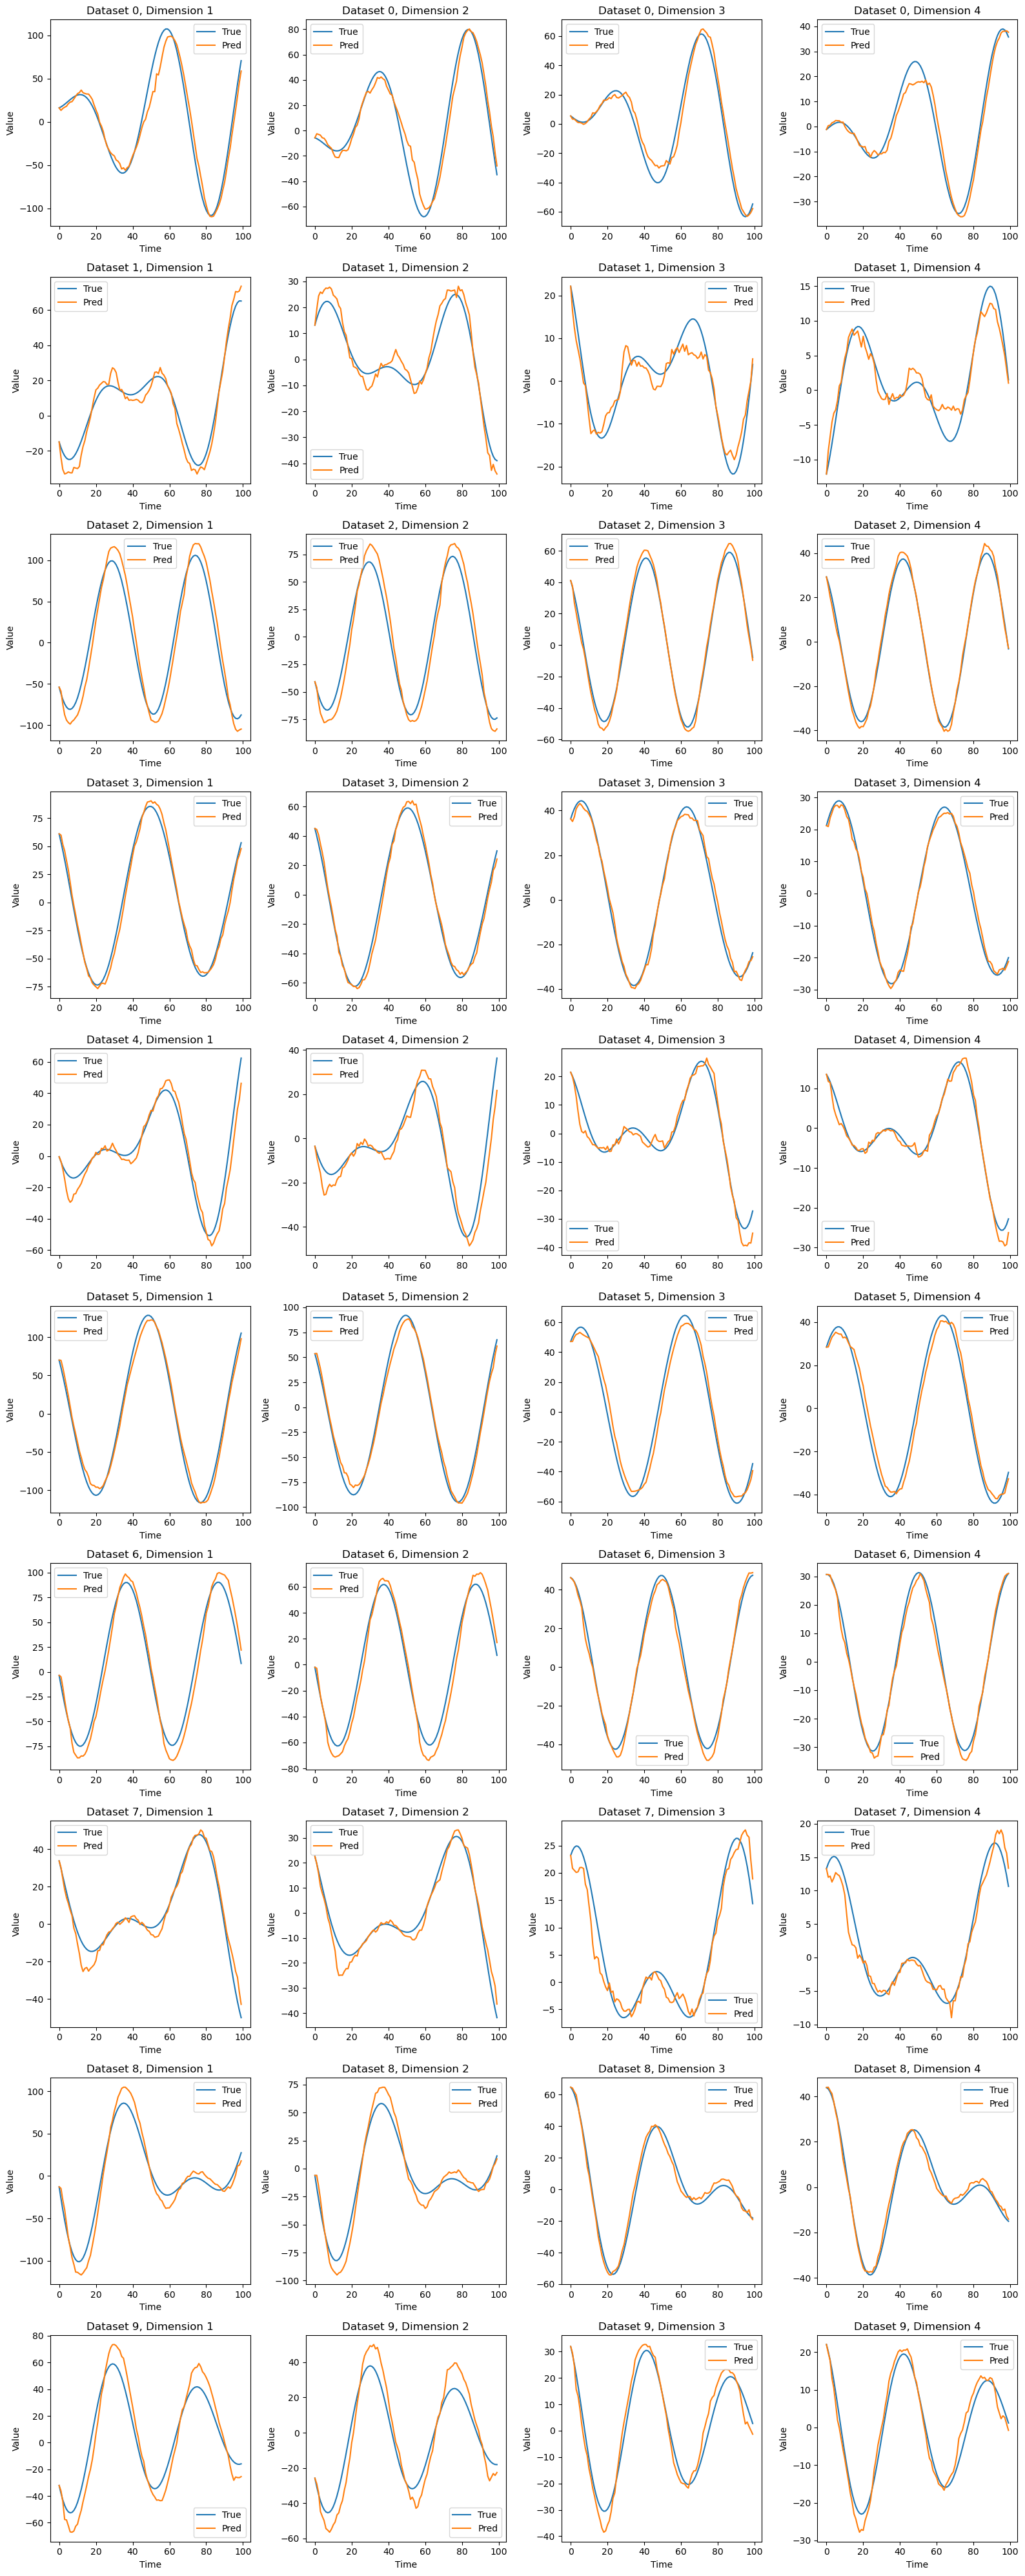

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming x_data_pca_dataset and x_data_pca_pred_dataset are your loaded datasets

ks = range(len(x_dataset))  # 选择六个代表性的k值进行绘图

fig, axs = plt.subplots(len(ks), 4, figsize=(16, len(ks) * 4))  # 增加figsize参数以适应更多子图

# 遍历每个选定的k值
for idx, k in enumerate(ks):
    x_true = x_pca_dataset_true[k]
    x_pred = x_pca_dataset_pred[k]
    # print(x_true.shape, x_pred.shape)

    for dim in range(4):
        # Plot for the first 4 dimensions of each dataset
        ax = axs[idx, dim]
        ax.plot(x_true[:, dim], label='True')  # Plot true values
        ax.plot(x_pred[:, dim], label='Pred')  # Plot predicted values
        ax.set_title(f'Dataset {idx}, Dimension {dim + 1}')  # Set title
        ax.set_xlabel('Time')  # Set x-axis label
        ax.set_ylabel('Value')  # Set y-axis label
        ax.legend()  # Show legend

plt.tight_layout()  # Adjust layout
plt.show()  # Display the figure


In [29]:
errors_pca = [x_pca_dataset_pred[i] - x_pca_dataset_true[i] for i in range(len(x_pca_dataset_true))]

cumulative_error_norms_pca = []
for k in range(4):
    cur_dim_norm = np.array([np.array([np.linalg.norm(errors_pca[i][:j+1,k]) for j in range(errors_pca[i].shape[0])]) for i in range(len(errors_pca))])
    cumulative_error_norms_pca.append(cur_dim_norm)

NameError: name 'cumulative_error_norms_pca' is not defined

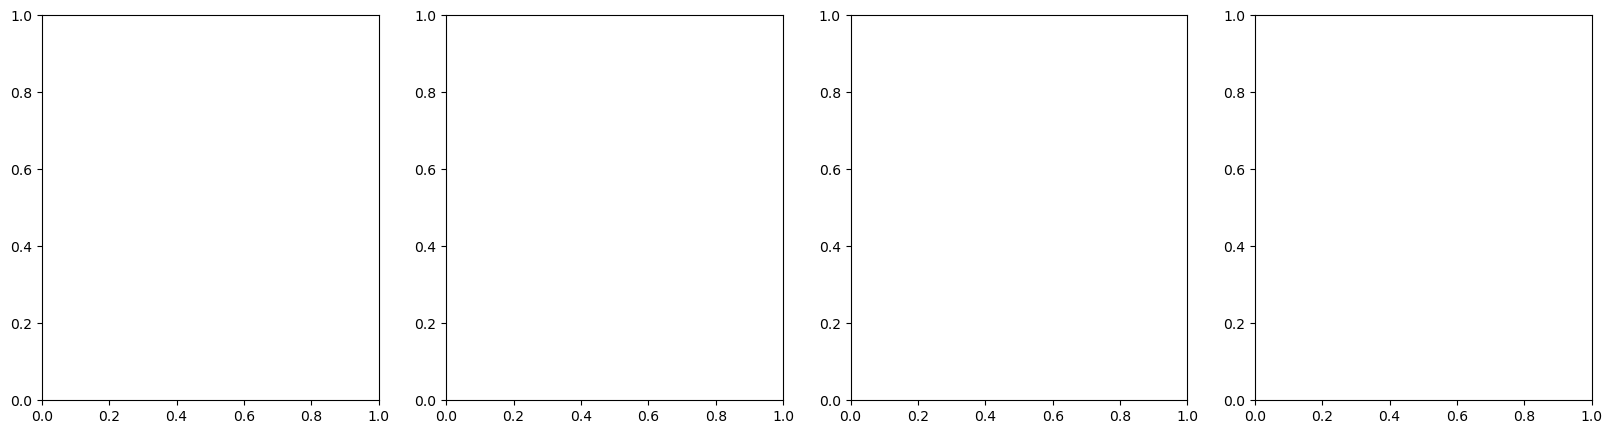

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 假设 window_size, cumulative_error_norms_pca, x_data_pca_traj 等变量已经定义

fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 创建一个1行4列的子图布局

for dim in range(4):
    # 计算平均相对误差和标准差
    mean_relative_errors_pca = np.mean([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_pca_dataset_true[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)
    std_relative_errors_pca = np.std([
        cumulative_error_norms_pca[dim][i] / np.linalg.norm(x_pca_dataset_true[i]) 
        for i in range(len(cumulative_error_norms_pca[dim]))
    ], axis=0)

    # 计算上下误差界限
    upper_bound = mean_relative_errors_pca + std_relative_errors_pca
    lower_bound = mean_relative_errors_pca - std_relative_errors_pca

    x_axis = range(mean_relative_errors_pca.shape[0])
    # 绘制平均误差曲线
    axs[dim].plot(x_axis, mean_relative_errors_pca, '-', label='Mean Cumulative Error')
    
    # 使用阴影表示误差范围
    axs[dim].fill_between(x_axis, lower_bound, upper_bound, color='gray', alpha=0.2)

    axs[dim].set_xlabel('Prediction Time Step')
    axs[dim].set_ylabel('Cumulative Error')
    axs[dim].set_title(f'Dimension {dim}')

plt.tight_layout()
plt.show()
